### 13. Rozkłady zliczeń po określonym czasie

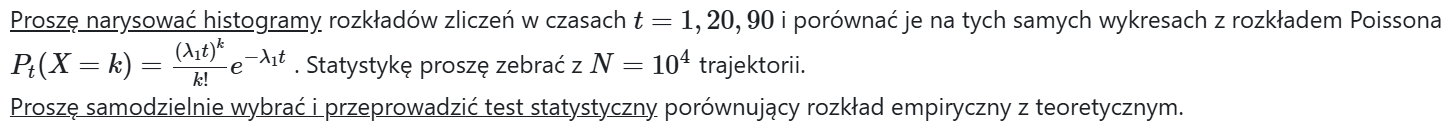

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [11]:
def scotts_bin_width(data):
    std_dev = np.std(data)
    bin_width = 3.49 * std_dev / np.cbrt(len(data)) # Scott's normal reference rule
    n_bins = np.ceil((max(data) - min(data)) / bin_width).astype(int)
    return n_bins

In [4]:
def poisson_distribution(lambda1, k):
    return (lambda1 ** k) * (math.e ** -lambda1) / math.factorial(k)

In [6]:
def generate_time(lambda1):
    u = random.random()
    return -np.log(u)/lambda1

def simulate_poisson(lambda1, tmin, tmax):
    events = []
    current_time = tmin
    while current_time < tmax:
        events.append(current_time)
        current_time += generate_time(lambda1)
    return events

In [38]:
lambda1 = 1 # one event per minute
tmin, tmax = 0, 90
n_trajectories = 100000
times = [1, 20, 90]

In [39]:
trajectories = \
[simulate_poisson(lambda1, tmin, tmax) for _ in range(n_trajectories)]

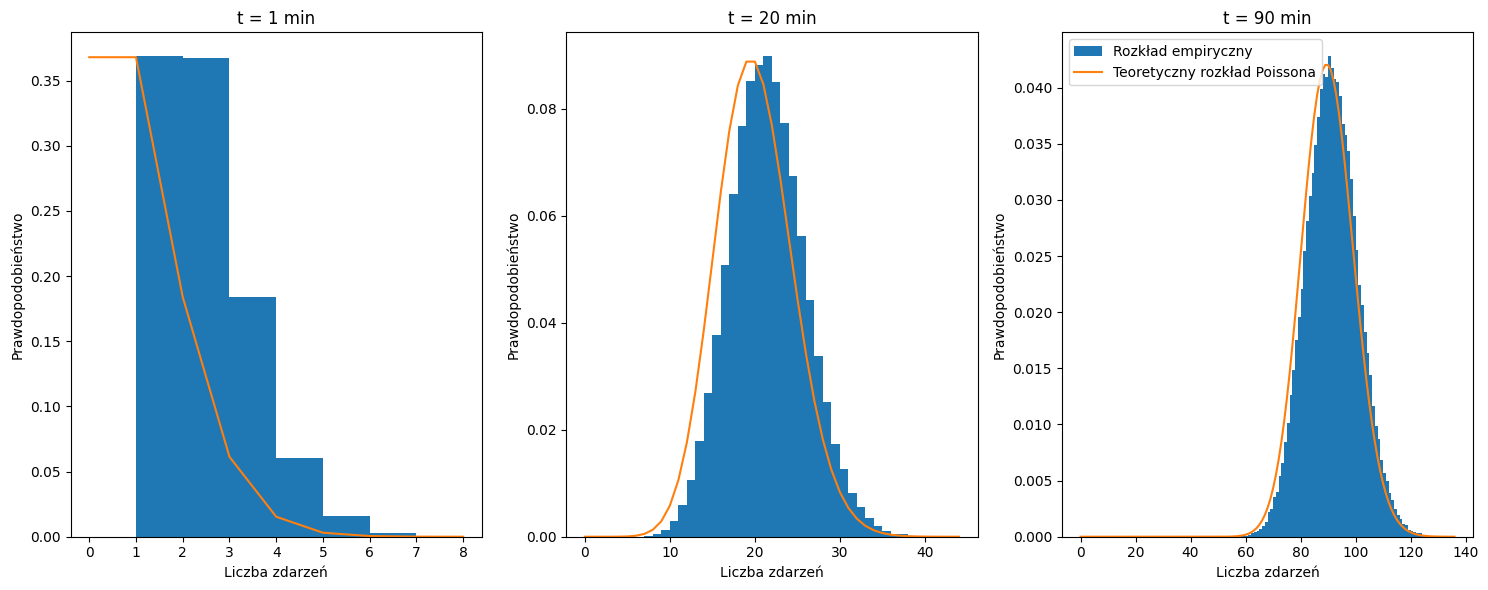

In [42]:
counts = defaultdict(list)
for traj in trajectories:
    for t in times:
        counts[t].append(sum(1 for event in traj if event <= t))

plt.figure(figsize=(15, 6))
for i, t in enumerate(times):
    plt.subplot(1, len(times), i+1) # 1 row, len(times) columns, i+1-th plot
    
    # https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
    # n_bins = scotts_bin_width(counts[t])
    n_bins = np.ceil(max(counts[t]) - min(counts[t])).astype(int) # looks best out of all tested methods
    plt.hist(counts[t], bins=n_bins, density=True, label="Rozkład empiryczny")

    max_count = max(counts[t])
    k_values = range(max_count+1)
    poisson_probs = [poisson_distribution(lambda1*t, k) for k in k_values]
    plt.plot(k_values, poisson_probs, label="Teoretyczny rozkład Poissona")

    plt.title(f"t = {t} min")
    plt.xlabel("Liczba zdarzeń")
    plt.ylabel("Prawdopodobieństwo")
    
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
from scipy.stats import chisquare

for t in times:
    empirical_counts = np.array(counts[t])
    
    num_bins = scotts_bin_width(empirical_counts)
    bins = np.linspace(min(empirical_counts), max(empirical_counts) + 1, num_bins + 1)
    
    observed, bin_edges = np.histogram(empirical_counts, bins=bins)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    expected = np.array([
        N * poisson_distribution(lambda1 * t, int(k)) for k in bin_centers
    ])
    
    chi2, p_value = chisquare(f_obs=observed, f_exp=expected)
    print(f"t = {t}: Chi-square = {chi2:.2f}, p-value = {p_value:.4f}")

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.353895910726164